In [13]:
"""
Portfolio Optimization using Reinforcement Learning
Key Components:
- PortfolioSimulator: Models investment environment
- ReinforcementLearner: Implements learning algorithm
- FinancialMathematics: Core financial calculations
"""

import numpy as np
import unittest

# --------------------------
# Financial Mathematics Core
# --------------------------
class FinancialMathematics:
    @staticmethod
    def exponential_utility(portfolio_value, risk_coefficient):
        """
        Calculate exponential utility of wealth
        Args:
            portfolio_value: Current investment portfolio value (float)
            risk_coefficient: Risk aversion parameter (γ > 0)
        """
        if np.isclose(risk_coefficient, 0):
            return portfolio_value
        return (1 - np.exp(-risk_coefficient * portfolio_value)) / risk_coefficient

    @staticmethod
    def binomial_outcome(random_input, up_probability, up_return, down_return):
        """
        Simulate binomial market outcome
        Returns:
            up_return if random_input < up_probability else down_return
        """
        return up_return if random_input < up_probability else down_return

In [14]:
# ------------------------
# Portfolio Simulation
# ------------------------
class PortfolioSimulator:
    def __init__(self, investment_horizon, risk_free_rate, risky_asset_distribution,
                 risk_coefficient, max_portfolio_value, portfolio_grid_size, allocation_options_count):
        """
        Args:
            investment_horizon: Number of time steps (T)
            risk_free_rate: Fixed return for safe asset (r_f)
            risky_asset_distribution: BinomialReturn parameters
            risk_coefficient: γ in utility function
            max_portfolio_value: Maximum portfolio value for discretization
            portfolio_grid_size: Number of discrete wealth states
            allocation_options_count: Number of possible asset allocations
        """
        self.time_steps = investment_horizon
        self.r_f = risk_free_rate
        self.risky_dist = risky_asset_distribution
        self.γ = risk_coefficient
        
        # Discretized portfolio values [0, max_portfolio_value]
        self.portfolio_grid = np.linspace(0, max_portfolio_value, portfolio_grid_size, dtype=np.float32)
        self.Δ_portfolio = max_portfolio_value / (portfolio_grid_size - 1)  # Grid spacing
        
        # Possible allocations to risky asset (α ∈ [0,1])
        self.allocation_options = np.linspace(0, 1, allocation_options_count, dtype=np.float32).round(2)

    def portfolio_transition(self, current_state, allocation_choice, market_randomness):
        """
        Execute one step of portfolio evolution
        Args:
            current_state: Tuple (portfolio_index, time_step)
            allocation_choice: Index in allocation_options
            market_randomness: Random number for market outcome
        Returns:
            (new_state, immediate_reward, terminal_flag)
        """
        portfolio_idx, time_step = current_state
        current_value = self.portfolio_grid[portfolio_idx]
        α = self.allocation_options[allocation_choice]
        
        # Market return realization
        market_return = FinancialMathematics.binomial_outcome(
            market_randomness, self.risky_dist.p, 
            self.risky_dist.a, self.risky_dist.b
        )
        
        # Portfolio evolution equation
        new_value = current_value * (1 + self.r_f + α*(market_return - self.r_f))
        new_time = time_step + 1
        
        # Discrete value approximation
        new_idx = int(round(new_value / self.Δ_portfolio))
        new_idx = np.clip(new_idx, 0, len(self.portfolio_grid)-1)
        
        # Terminal condition check
        if new_time >= self.time_steps:
            reward = FinancialMathematics.exponential_utility(new_value, self.γ)
            is_terminal = True
        else:
            reward = 0.0
            is_terminal = False
            
        return (new_idx, new_time), reward, is_terminal

    def initialize_portfolio(self):
        """Generate valid initial state (portfolio_value ∈ [1,2])"""
        valid_indices = np.where((self.portfolio_grid >= 1.0) & 
                               (self.portfolio_grid <= 2.0))[0]
        if not valid_indices.size:
            raise ValueError("No valid initial portfolio values")
        return (np.random.choice(valid_indices), 0)

In [15]:
# --------------------------
# Reinforcement Learning Core
# --------------------------
class ReinforcementLearner:
    def __init__(self, state_space_size, action_space_size, total_episodes,
                 learning_rate=0.2, discount_factor=0.99, exploration_rate=0.1,
                 min_exploration=0.01, exploration_decay_start=500, exploration_decay_end=1000):
        """
        Args:
            state_space_size: Tuple (portfolio_states, time_steps)
            action_space_size: Number of allocation choices
            total_episodes: Total training episodes
        """
        self.state_dims = state_space_size
        self.action_count = action_space_size
        self.total_episodes = total_episodes
        
        # Learning parameters
        self.α = np.float32(learning_rate)
        self.γ = np.float32(discount_factor)
        self.ε = exploration_rate
        self.ε_min = min_exploration
        
        # Exploration decay configuration
        self.decay_start = exploration_decay_start
        self.decay_duration = exploration_decay_end - exploration_decay_start
        self.ε_decay = (exploration_rate - min_exploration)/self.decay_duration
        
        # Q-value matrix initialization
        self.q_matrix = np.zeros((*state_space_size, action_space_size), dtype=np.float32)
        
        # Function approximation parameters
        self.state_neighborhood = np.arange(-5, 6, dtype=np.int32)
        self.action_neighborhood = np.arange(-1, 2, dtype=np.int32)
        self.state_weights = np.exp(-0.1 * self.state_neighborhood**2).astype(np.float32)
        self.action_weights = np.exp(-0.8 * self.action_neighborhood**2).astype(np.float32)

    def select_action(self, current_state, exploration_randomness):
        """
        ε-greedy action selection
        Args:
            current_state: Tuple (portfolio_idx, time_step)
            exploration_randomness: Random number for exploration decision
        """
        if exploration_randomness < self.ε:
            return np.random.randint(0, self.action_count)
        portfolio_idx, time_step = current_state
        return np.argmax(self.q_matrix[portfolio_idx, time_step])

    def update_value_estimates(self, current_state, action, reward, next_state):
        """
        Perform Q-learning update with function approximation
        Returns temporal difference error for monitoring
        """
        port_idx, time_step = current_state
        current_q = self.q_matrix[port_idx, time_step, action]
        
        # Calculate target value
        if next_state[1] < self.state_dims[1]:  # Check time bounds
            future_q = np.max(self.q_matrix[next_state[0], next_state[1]])
        else:
            future_q = 0.0
        target = reward + self.γ * future_q
        
        # Calculate TD error
        td_error = target - current_q
        
        # Spread update to neighboring states/actions
        for state_offset in self.state_neighborhood:
            neighbor_idx = port_idx + state_offset
            if 0 <= neighbor_idx < self.state_dims[0]:
                for action_offset in self.action_neighborhood:
                    action_idx = action + action_offset
                    if 0 <= action_idx < self.action_count:
                        weight = (self.state_weights[state_offset + 5] * 
                                 self.action_weights[action_offset + 1])
                        update = self.α * weight * td_error
                        self.q_matrix[neighbor_idx, time_step, action_idx] += update
        
        return td_error

In [16]:
# --------------------------
# Training Process
# --------------------------
def train_investment_strategy(simulator, learner):
    """
    Execute RL training process
    Returns:
        metrics: Dictionary containing training history
    """
    metrics = {
        'theoretical_discrepancy': np.zeros(learner.total_episodes, np.float32),
        'learning_signals': np.zeros(learner.total_episodes, np.float32),
        'terminal_utilities': np.zeros(learner.total_episodes, np.float32),
        'risk_exposures': np.zeros(learner.total_episodes, np.float32)
    }
    
    # Pre-generate all randomness for reproducibility
    randomness_pool = np.random.random((learner.total_episodes, simulator.time_steps*2))
    
    for episode in range(learner.total_episodes):
        state = simulator.initialize_portfolio()
        episode_metrics = {
            'td_errors': [],
            'allocations': [],
            'theoretical_gaps': []
        }
        rnd_idx = 0  # Index into randomness pool
        
        for t in range(simulator.time_steps):
            # Action selection
            action = learner.select_action(state, randomness_pool[episode, rnd_idx])
            rnd_idx += 1
        
            # Environment step
            next_state, reward, terminal = simulator.portfolio_transition(
                state, action, randomness_pool[episode, rnd_idx]
            )
            rnd_idx += 1
            
            # Learning update
            td_error = learner.update_value_estimates(state, action, reward, next_state)
            
            # Record metrics
            episode_metrics['td_errors'].append(abs(td_error))
            chosen_allocation = simulator.allocation_options[action]
            episode_metrics['allocations'].append(chosen_allocation)
            
            if terminal:
                metrics['terminal_utilities'][episode] = reward
            
            state = next_state
        
        # Update exploration rate
        if learner.decay_start <= episode < learner.decay_start + learner.decay_duration:
            learner.ε -= learner.ε_decay
        
        # Aggregate episode metrics
        metrics['learning_signals'][episode] = np.mean(episode_metrics['td_errors'])
        metrics['risk_exposures'][episode] = np.mean(episode_metrics['allocations'])
        
        # Logging
        if episode % 1000 == 0:
            print(f"Episode {episode} | "
                  f"ε={learner.ε:.3f} | "
                  f"Avg Utility={metrics['terminal_utilities'][episode]:.2f}")
    
    return metrics

In [17]:
# --------------------------
# Unit Tests
# --------------------------
class TestInvestmentStrategy(unittest.TestCase):
    def setUp(self):
        self.risk_free = 0.01
        self.risky_asset = BinomialReturn(0.9, 0.1, -0.1)
        self.γ = 0.2
        self.simulator = PortfolioSimulator(
            investment_horizon=2,
            risk_free_rate=self.risk_free,
            risky_asset_distribution=self.risky_asset,
            risk_coefficient=self.γ,
            max_portfolio_value=2.0,
            portfolio_grid_size=5,
            allocation_options_count=3
        )
        
    def test_portfolio_evolution(self):
        initial_state = (2, 0)  # Middle of the grid
        new_state, reward, done = self.simulator.portfolio_transition(
            initial_state, 2, 0.5)
        self.assertEqual(new_state[1], 1)
        self.assertFalse(done)

    def test_utility_calculation(self):
        utility = FinancialMathematics.exponential_utility(1.0, 0.0)
        self.assertAlmostEqual(utility, 1.0)

class BinomialReturn:
    """Container for binomial distribution parameters"""
    def __init__(self, up_probability, up_return, down_return):
        self.p = up_probability
        self.a = up_return
        self.b = down_return

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


## Convergence Test

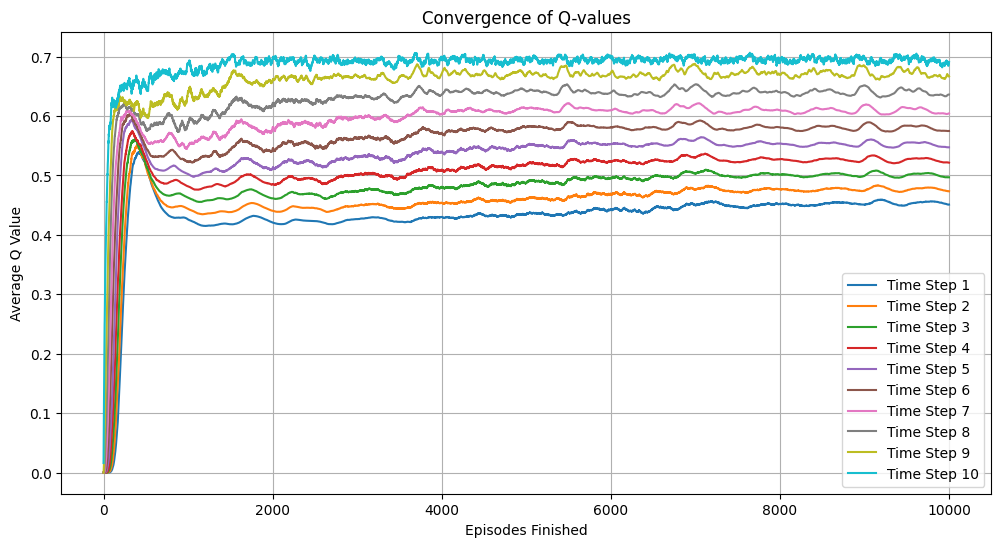

In [20]:
import matplotlib.pyplot as plt

def train_investment_strategy_with_convergence_test(simulator, learner):
    metrics = {
        'average_q_values': np.zeros((learner.state_dims[1], learner.total_episodes), dtype=np.float32),
        'terminal_utilities': np.zeros(learner.total_episodes, np.float32)
    }

    randomness_pool = np.random.random((learner.total_episodes, simulator.time_steps * 2))

    for episode in range(learner.total_episodes):
        state = simulator.initialize_portfolio()

        for t in range(simulator.time_steps):
            action = learner.select_action(state, randomness_pool[episode, t])
            next_state, reward, terminal = simulator.portfolio_transition(state, action,
                                                                          randomness_pool[episode, t + 1])
            td_error = learner.update_value_estimates(state, action, reward, next_state)

            # Record average Q-values
            metrics['average_q_values'][t, episode] = np.mean(learner.q_matrix[:, t, :])

            if terminal:
                metrics['terminal_utilities'][episode] = reward

            state = next_state

    return metrics


# Visualization of average Q-values
def plot_convergence(metrics):
    plt.figure(figsize=(12, 6))
    for t in range(metrics['average_q_values'].shape[0]):
        plt.plot(metrics['average_q_values'][t], label=f'Time Step {t + 1}')
    plt.xlabel('Episodes Finished')
    plt.ylabel('Average Q Value')
    plt.title('Convergence of Q-values')
    plt.legend()
    plt.grid()
    plt.show()


# Define parameters for the PortfolioSimulator
investment_horizon = 10  # Total time steps
risk_free_rate = 0.02  # Risk-free interest rate (2%)
risky_asset_distribution = BinomialReturn(up_probability=0.6, up_return=0.15, down_return=-0.1)  # Binomial distribution for risky asset
risk_coefficient = 0.3  # Risk aversion coefficient (γ)
max_portfolio_value = 5.0  # Maximum portfolio value for discretization
portfolio_grid_size = 10  # Number of discrete wealth states
allocation_options_count = 5  # Number of possible asset allocations

# Define parameters for the ReinforcementLearner
state_space_size = (portfolio_grid_size, investment_horizon)  # State space dimensions
action_space_size = allocation_options_count  # Number of actions (allocations)
total_episodes = 10000  # Total training episodes
learning_rate = 0.1  # Learning rate (α)
discount_factor = 0.95  # Discount factor (γ)
exploration_rate = 1.0  # Initial exploration rate (ε)
min_exploration = 0.01  # Minimum exploration rate
exploration_decay_start = 5000  # Episode at which to start decaying exploration
exploration_decay_end = 30000  # Episode at which to end exploration decay

# Initialize the PortfolioSimulator
simulator = PortfolioSimulator(
    investment_horizon=investment_horizon,
    risk_free_rate=risk_free_rate,
    risky_asset_distribution=risky_asset_distribution,
    risk_coefficient=risk_coefficient,
    max_portfolio_value=max_portfolio_value,
    portfolio_grid_size=portfolio_grid_size,
    allocation_options_count=allocation_options_count
)

# Initialize the ReinforcementLearner
learner = ReinforcementLearner(
    state_space_size=state_space_size,
    action_space_size=action_space_size,
    total_episodes=total_episodes,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    exploration_rate=exploration_rate,
    min_exploration=min_exploration,
    exploration_decay_start=exploration_decay_start,
    exploration_decay_end=exploration_decay_end
)

metrics = train_investment_strategy_with_convergence_test(simulator, learner)
plot_convergence(metrics)

## Conditional Optimal Test

In [28]:
conditions = [
    {
        'name': 'Condition 1',
        'a': 0.05,
        'b': -0.05,
        'p': 0.7,
        'r': 0.02,
        'expected_behavior': 'Risk-free asset preferred'
    },
    {
        'name': 'Condition 2',
        'a': 0.07,
        'b': -0.05,
        'p': 0.7,
        'r': 0.02,
        'expected_behavior': 'Risky asset preferred (higher expected return)'
    },
    {
        'name': 'Condition 3',
        'a': 0.07,
        'b': -0.05,
        'p': 0.9,
        'r': 0.02,
        'expected_behavior': 'Risky asset preferred (higher probability of profit)'
    }
]

In [29]:
# Common parameters
investment_horizon = 10
risk_coefficient = 0.00005  # Risk aversion parameter (α)
max_portfolio_value = 10.0
portfolio_grid_size = 100
allocation_options_count = 20
total_episodes = 10000

# Learning parameters
learning_rate = 0.2
discount_factor = 0.99
exploration_rate = 0.1
min_exploration = 0.01
exploration_decay_start = 500
exploration_decay_end = 1000


Testing Condition 1: Risk-free asset preferred
Episode 0 | ε=0.100 | Avg Utility=1.13
Episode 1000 | ε=0.010 | Avg Utility=1.44
Episode 2000 | ε=0.010 | Avg Utility=1.44
Episode 3000 | ε=0.010 | Avg Utility=1.65
Episode 4000 | ε=0.010 | Avg Utility=1.65
Episode 5000 | ε=0.010 | Avg Utility=1.65
Episode 6000 | ε=0.010 | Avg Utility=1.03
Episode 7000 | ε=0.010 | Avg Utility=2.20
Episode 8000 | ε=0.010 | Avg Utility=2.10
Episode 9000 | ε=0.010 | Avg Utility=1.75
Average allocation to risky asset: 0.06
Expected behavior: Risk-free asset preferred

Wealth Change Simulations:
Simulation 1 - Wealth Change: [1.2121212, 1.3131313, 1.3131313, 1.4141414, 1.5151515, 1.6161616, 1.5151515, 1.5151515, 1.6161616, 1.6161616, 1.6161616]
Simulation 2 - Wealth Change: [1.7171717, 1.8181819, 1.8181819, 1.8181819, 1.919192, 1.919192, 1.919192, 1.919192, 2.020202, 2.020202, 2.121212]
Simulation 3 - Wealth Change: [1.010101, 1.010101, 1.010101, 1.010101, 1.010101, 1.010101, 1.010101, 1.010101, 1.010101, 1.01

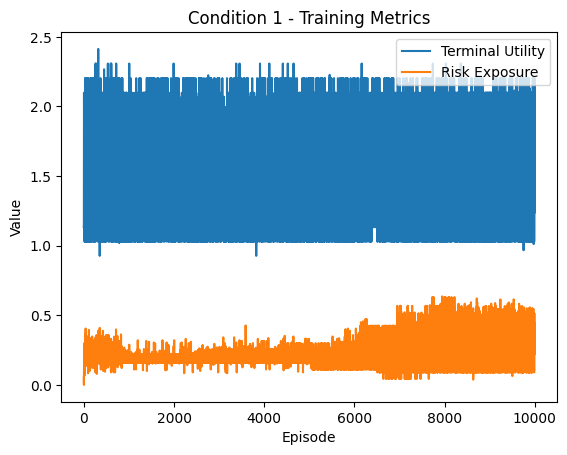


Testing Condition 2: Risky asset preferred (higher expected return)
Episode 0 | ε=0.100 | Avg Utility=1.96
Episode 1000 | ε=0.010 | Avg Utility=2.06
Episode 2000 | ε=0.010 | Avg Utility=2.27
Episode 3000 | ε=0.010 | Avg Utility=1.24
Episode 4000 | ε=0.010 | Avg Utility=2.27
Episode 5000 | ε=0.010 | Avg Utility=1.24
Episode 6000 | ε=0.010 | Avg Utility=1.34
Episode 7000 | ε=0.010 | Avg Utility=1.96
Episode 8000 | ε=0.010 | Avg Utility=1.96
Episode 9000 | ε=0.010 | Avg Utility=1.96
Average allocation to risky asset: 0.08
Expected behavior: Risky asset preferred (higher expected return)

Wealth Change Simulations:
Simulation 1 - Wealth Change: [1.010101, 1.1111112, 1.2121212, 1.3131313, 1.3131313, 1.4141414, 1.5151515, 1.6161616, 1.6161616, 1.7171717, 1.7171717]
Simulation 2 - Wealth Change: [1.1111112, 1.2121212, 1.3131313, 1.4141414, 1.5151515, 1.6161616, 1.6161616, 1.7171717, 1.8181819, 1.8181819, 1.8181819]
Simulation 3 - Wealth Change: [1.1111112, 1.2121212, 1.1111112, 1.2121212, 1.

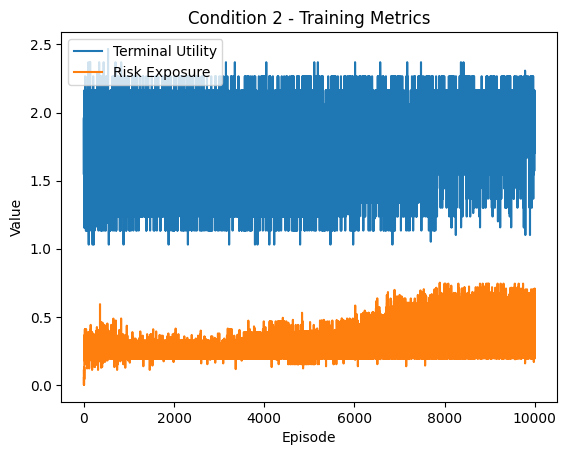


Testing Condition 3: Risky asset preferred (higher probability of profit)
Episode 0 | ε=0.100 | Avg Utility=1.75
Episode 1000 | ε=0.010 | Avg Utility=1.24
Episode 2000 | ε=0.010 | Avg Utility=1.96
Episode 3000 | ε=0.010 | Avg Utility=1.85
Episode 4000 | ε=0.010 | Avg Utility=2.47
Episode 5000 | ε=0.010 | Avg Utility=1.75
Episode 6000 | ε=0.010 | Avg Utility=1.03
Episode 7000 | ε=0.010 | Avg Utility=2.16
Episode 8000 | ε=0.010 | Avg Utility=2.06
Episode 9000 | ε=0.010 | Avg Utility=2.06
Average allocation to risky asset: 0.07
Expected behavior: Risky asset preferred (higher probability of profit)

Wealth Change Simulations:
Simulation 1 - Wealth Change: [1.2121212, 1.3131313, 1.4141414, 1.5151515, 1.6161616, 1.7171717, 1.7171717, 1.8181819, 1.8181819, 1.919192, 2.020202]
Simulation 2 - Wealth Change: [1.6161616, 1.7171717, 1.8181819, 1.8181819, 1.8181819, 1.919192, 1.919192, 1.919192, 1.8181819, 1.919192, 2.020202]
Simulation 3 - Wealth Change: [1.4141414, 1.5151515, 1.6161616, 1.71717

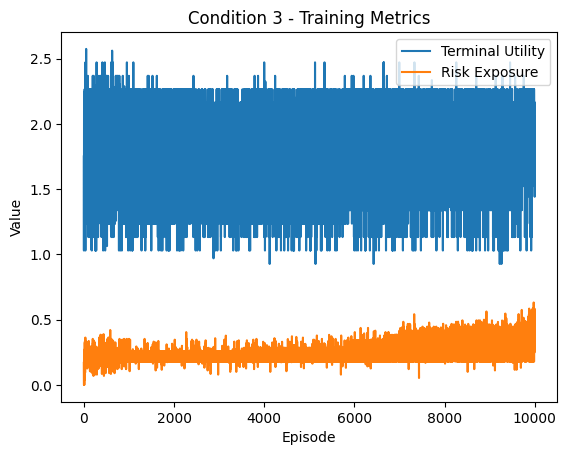

In [30]:
def simulate_wealth_change(simulator, learner, num_simulations=10):
    """
    Simulate portfolio evolution using the learned policy and track wealth change.
    Args:
        simulator: PortfolioSimulator instance
        learner: ReinforcementLearner instance
        num_simulations: Number of simulations to run
    """
    final_policy = np.argmax(learner.q_matrix, axis=2)
    
    for sim in range(num_simulations):
        state = simulator.initialize_portfolio()
        wealth_history = [simulator.portfolio_grid[state[0]]]
        
        for t in range(simulator.time_steps):
            action = final_policy[state[0], state[1]]
            next_state, _, _ = simulator.portfolio_transition(state, action, np.random.random())
            wealth_history.append(simulator.portfolio_grid[next_state[0]])
            state = next_state
        
        print(f"Simulation {sim + 1} - Wealth Change: {wealth_history}")

# Modify the main loop to include wealth change simulation
for condition in conditions:
    print(f"\nTesting {condition['name']}: {condition['expected_behavior']}")
    
    # Set up the risky asset distribution
    risky_asset_distribution = BinomialReturn(condition['p'], condition['a'], condition['b'])
    
    # Initialize the simulator
    simulator = PortfolioSimulator(
        investment_horizon=investment_horizon,
        risk_free_rate=condition['r'],
        risky_asset_distribution=risky_asset_distribution,
        risk_coefficient=risk_coefficient,
        max_portfolio_value=max_portfolio_value,
        portfolio_grid_size=portfolio_grid_size,
        allocation_options_count=allocation_options_count
    )
    
    # Initialize the learner
    state_space_size = (portfolio_grid_size, investment_horizon)
    action_space_size = allocation_options_count
    learner = ReinforcementLearner(
        state_space_size=state_space_size,
        action_space_size=action_space_size,
        total_episodes=total_episodes,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        exploration_rate=exploration_rate,
        min_exploration=min_exploration,
        exploration_decay_start=exploration_decay_start,
        exploration_decay_end=exploration_decay_end
    )
    
    # Train the investment strategy
    metrics = train_investment_strategy(simulator, learner)
    
    # Analyze the learned policy
    final_policy = np.argmax(learner.q_matrix, axis=2)
    average_allocation = np.mean(simulator.allocation_options[final_policy])
    
    print(f"Average allocation to risky asset: {average_allocation:.2f}")
    print(f"Expected behavior: {condition['expected_behavior']}")
    
    # Simulate wealth change using the learned policy
    print("\nWealth Change Simulations:")
    simulate_wealth_change(simulator, learner, num_simulations=5)
    
    # Plot the results (optional)
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(metrics['terminal_utilities'], label='Terminal Utility')
    plt.plot(metrics['risk_exposures'], label='Risk Exposure')
    plt.title(f"{condition['name']} - Training Metrics")
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.legend()
    plt.show()